In [1]:
import os, shutil

In [2]:
# Cleanup previous run
dirs_to_remove=['diffr, pmi']
files_to_remove=['diffr.h5','5udc.pdb']

In [3]:
for d in dirs_to_remove:
    if os.path.isdir(d):
        shutil.rmtree(d)
for f in files_to_remove:
    if os.path.isfile(f):
        os.remove(f)
    

# Demo Notebook for start-to-end single-particle imaging

## Header 

In [4]:
# Activate matplotlib magic
%matplotlib inline

In [5]:
# Import all SimEx modules
import SimEx
from SimEx import *

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


initializing ocelot...


## Step 1: Source diagnostics 

In [6]:
source_analysis = XFELPhotonAnalysis(input_path="FELsource_out_0000001.h5")


 Start initialization.

 Loading wavefront from FELsource_out_0000001.h5.
 ... done.

 Getting intensities.
 ... done.
 Data dimensions =  (104, 104, 651)

 Masking NANs.
 ... done.



 Plotting total power.
Pulse energy 0.001 J


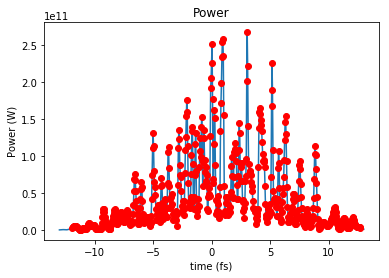

In [7]:
source_analysis.plotTotalPower()


 Plotting total power.

 Switching to frequency domain.


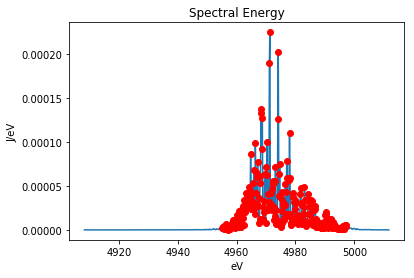

In [8]:
source_analysis.plotTotalPower(spectrum=True)


 Plotting intensity map.
R-space


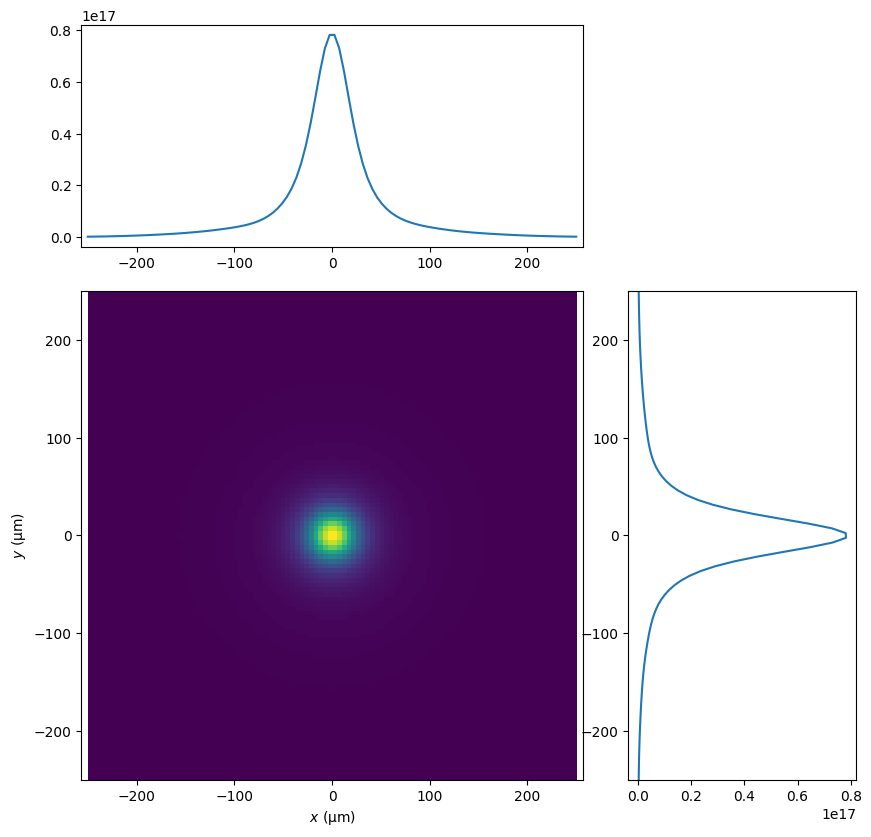

In [9]:
source_analysis.plotIntensityMap()

## Step 2: Propagation through beamline

### Import beamline for WPG 

In [10]:
from prop import exfel_spb_kb_beamline

### Propagator setup

In [11]:
propagation_parameters = WavePropagatorParameters(beamline=exfel_spb_kb_beamline)

In [12]:
propagator = XFELPhotonPropagator(parameters=propagation_parameters,
                                  input_path='FELsource_out_0000001.h5',
                                  output_path='prop_out.h5')

In [ ]:
#propagator.backengine()

In [ ]:
#propagator.saveH5()

In [13]:
prop_analysis=XFELPhotonAnalysis(input_path='prop_out.h5')


 Start initialization.

 Loading wavefront from prop_out.h5.
 ... done.

 Getting intensities.
 ... done.
 Data dimensions =  (78, 78, 651)

 Masking NANs.
 ... done.



 Plotting total power.

 Switching to frequency domain.


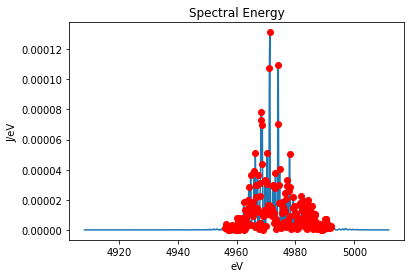

In [14]:
prop_analysis.plotTotalPower(spectrum=True)


 Plotting intensity map.
R-space


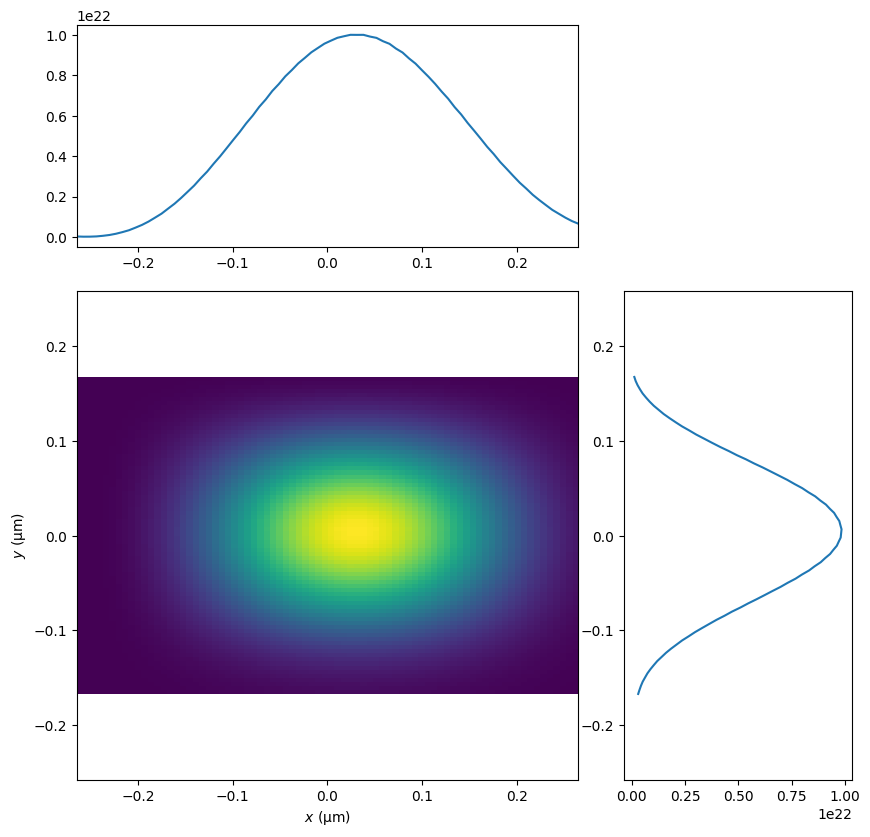

In [15]:
prop_analysis.plotIntensityMap()

## Step 3: Photon-Matter interaction (demonstrator) 

In [16]:
pmi_parameters={"number_of_trajectories" : 1,
                "random_rotation" : False}
photon_matter_interactor=XMDYNDemoPhotonMatterInteractor(parameters=pmi_parameters,
                                                         input_path='prop_out.h5',
                                                         output_path='pmi',
                                                         sample_path='5udc.pdb')

Sample file 5udc.pdb was not found. Will attempt to query from RCSB protein data bank.


In [17]:
photon_matter_interactor.backengine(); photon_matter_interactor.saveH5()

Previous module:  s2e_spi
  NOT: data
  NOT: history
info
misc
params
version
['arrEhor', 'arrEver']
[('arrEhor', <HDF5 dataset "arrEhor": shape (78, 78, 651, 2), type "<f4">), ('arrEver', <HDF5 dataset "arrEver": shape (78, 78, 651, 2), type "<f4">)]
PDB file 5udc.pdb could not be found. Attempting to query from protein database server.


## Step 4: Scattering 

### Configure Detector geometry

#### One panel

In [18]:
panel = DetectorPanel(ranges={"fast_scan_min" : 0, "fast_scan_max" : 100,
                              "slow_scan_min" : 0, "slow_scan_max" : 100},
                      pixel_size=6*220.0e-6*meter,
                      energy_response=1.0/electronvolt,
                      distance_from_interaction_plane=0.13*meter,
                      corners={"x" : -49, "y": -49},
                      saturation_adu=1.e6,
                      )

In [19]:
detector_geometry = DetectorGeometry(panels=panel,)

### Configure the Diffractor Parameters

In [20]:
diffraction_parameters = SingFELPhotonDiffractorParameters(
                                               uniform_rotation=False,
                                               slice_interval=100,
                                               number_of_slices=100,
                                               number_of_diffraction_patterns=1,
                                               detector_geometry=detector_geometry,
                                               forced_mpi_command='mpirun -np 1',
                                              )

### Initialize the Diffractor 

In [21]:
diffractor = SingFELPhotonDiffractor(parameters=diffraction_parameters,
                                     input_path='pmi',
                                     output_path="diffr")

### Run the scattering simulation

In [22]:
diffractor.backengine()

0

In [24]:
diffractor.saveH5()

## Analysis 

### Setup analysis object 

In [25]:
spi_analysis = DiffractionAnalysis(diffractor.output_path,
                                   pattern_indices=[1],
                                   poissonize=True)

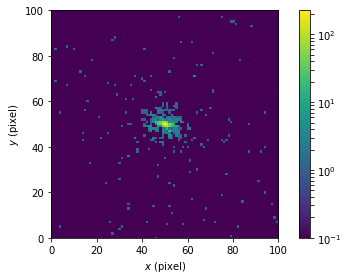

In [26]:
spi_analysis.plotPattern(logscale=True)